In [1]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
from angle_estimation_model import AngleDataset, AngleEstimationModel, train_epoch, evaluate_model, mean_shift, split_dataset
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using", device)

Using mps


In [3]:
N = 8               # Number of orientations per task
M = 9               # Number of tasks (discretization)
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
NUM_EPOCHS = 30
IMG_SIZE = 224

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
data_dir = "/Users/vlad.sarm/Documents/sausage_rotation_estimation/data"  # Update this path to your dataset
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
raw_dir = os.path.join(data_dir, "by_degrees")

In [6]:
split_dataset(raw_dir, data_dir, val_ratio=0.1)

Dataset split complete: 1205 training images, 360 validation images


(1205, 360)

In [7]:
train_dataset = AngleDataset(
    root_dir=train_dir,
    transform=train_transforms,
    discretization_params={'N': N, 'M': M}
)

val_dataset = AngleDataset(
    root_dir=val_dir,
    transform=val_transforms,
    discretization_params={'N': N, 'M': M}
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 1205
Validation samples: 360


In [8]:
# Initialize model
model = AngleEstimationModel(N=N, M=M, feature_extract=False)  # Set feature_extract=False to fine-tune the whole model
model = model.to(device)

# Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
TRAIN = True  # Set to False to skip training and load the model directly

if TRAIN:
    print("Starting training...")
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_loss, train_mae = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_mae = evaluate_model(model, train_loader, criterion, device)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
else:
    checkpoint = torch.load("/Users/vlad.sarm/Documents/sausage_rotation_estimation/angle_recognition/angle_estimation_model.pth", map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()


Starting training...


  3%|▎         | 1/30 [03:04<1:29:15, 184.67s/it]

Epoch [1/30], Train Loss: 7.8389, Train MAE: 44.7148
Val Loss: 8.8362, Val MAE: 33.6394


  7%|▋         | 2/30 [06:04<1:24:47, 181.69s/it]

Epoch [2/30], Train Loss: 3.0562, Train MAE: 29.1271
Val Loss: 3.7053, Val MAE: 31.0061


 10%|█         | 3/30 [09:02<1:21:02, 180.08s/it]

Epoch [3/30], Train Loss: 2.4611, Train MAE: 28.4820
Val Loss: 3.6159, Val MAE: 30.4634


 13%|█▎        | 4/30 [12:00<1:17:43, 179.37s/it]

Epoch [4/30], Train Loss: 2.1976, Train MAE: 28.3322
Val Loss: 3.4234, Val MAE: 30.1251


 17%|█▋        | 5/30 [14:58<1:14:33, 178.94s/it]

Epoch [5/30], Train Loss: 1.8270, Train MAE: 28.2802
Val Loss: 3.1888, Val MAE: 26.9816


 20%|██        | 6/30 [17:56<1:11:24, 178.53s/it]

Epoch [6/30], Train Loss: 1.6230, Train MAE: 28.4259
Val Loss: 2.2687, Val MAE: 29.3642


 23%|██▎       | 7/30 [20:59<1:08:58, 179.95s/it]

Epoch [7/30], Train Loss: 1.3516, Train MAE: 28.6662
Val Loss: 2.3579, Val MAE: 29.0477


In [ ]:
print("Evaluating model...")
mae = evaluate_model(model, val_loader, criterion, device)
print(f"Mean Absolute Error: {mae:.2f} degrees")

Evaluating model...


TypeError: unsupported format string passed to tuple.__format__

In [ ]:
print("Saving model...")
torch.save(model.state_dict(), "angle_estimation_model.pth")
print("Model saved successfully!")

Saving model...
Model saved successfully!


In [ ]:
def visualize_predictions(model, dataset, device, num_samples=5, save_path=None):
    """
    Visualize model predictions on random samples with cleaner output
    
    Args:
        model: The angle estimation model
        dataset: Dataset containing the samples
        device: Device to run inference on
        num_samples: Number of samples to visualize
        save_path: Optional path to save the visualization
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import torch
    import torch.nn.functional as F
    from torchvision import transforms
    
    model.eval()
    
    # For denormalizing images
    denormalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    to_pil = transforms.ToPILImage()
    
    # Get random indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    plt.figure(figsize=(10, 2*num_samples))
    
    for i, idx in enumerate(indices):
        img, _, true_angle = dataset[idx]
        
        # Make prediction
        img_tensor = img.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(img_tensor)
        
        # Convert to angle
        sample_outputs = []
        for m in range(model.M):
            softmax_probs = F.softmax(outputs[m][0], dim=0)
            sample_outputs.append(softmax_probs)
        
        predicted_angle = mean_shift(sample_outputs, model.N, model.M)
        
        error = predicted_angle - true_angle.item()
        error = abs((error + 180) % 360 - 180)
        ambiguity_note = f"Error: {error:.1f}°"
        
        # Display the image and angles
        # Properly denormalize the image to avoid artifacts
        img_display = denormalize(img.clone())
        img_display = torch.clamp(img_display, 0, 1)  # Ensure values are in valid range
        img_display = to_pil(img_display)
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(img_display)
        plt.title(f"True: {true_angle.item():.1f}°, Predicted: {predicted_angle:.1f}°{ambiguity_note}")
        
        # Draw angle indicators
        center_x, center_y = img_display.width / 2, img_display.height / 2
        radius = min(center_x, center_y) * 0.25  # Smaller radius for cleaner look
        
        # Draw true angle (red)
        angle_rad = np.radians(true_angle.item())
        end_x = center_x + radius * np.cos(angle_rad)
        end_y = center_y - radius * np.sin(angle_rad)  # Negative because y-axis is flipped in images
        plt.plot([center_x, end_x], [center_y, end_y], 'r-', linewidth=2)
        
        # Draw predicted angle (blue)
        angle_rad = np.radians(predicted_angle)
        end_x = center_x + radius * np.cos(angle_rad)
        end_y = center_y - radius * np.sin(angle_rad)
        plt.plot([center_x, end_x], [center_y, end_y], 'b-', linewidth=2)
        
        plt.axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

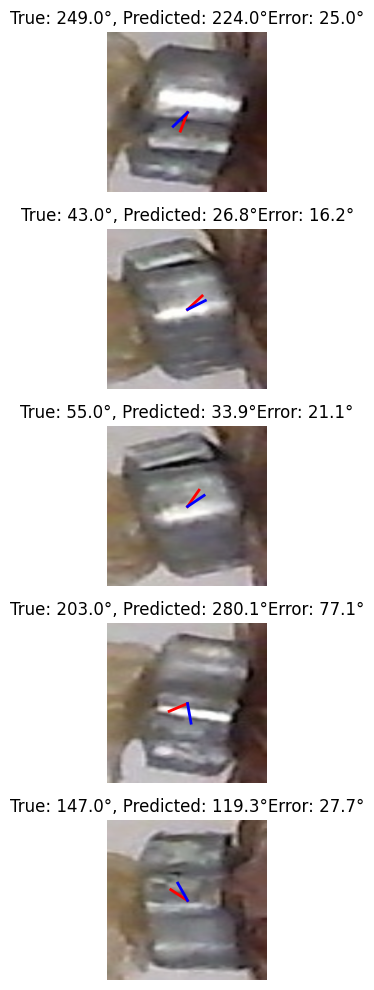

In [ ]:
visualize_predictions(model, val_dataset, device)